In [4]:
import torch
import numpy as np
import time
import math
import random
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report

In [5]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## GPU

Jednym z kluczowych udogodnień PyTorcha jest możliwość szybkiego i prostego przenoszenia obliczeń między CPU a GPU.

In [6]:
torch.backends.mps.is_available()

True

In [7]:
device = torch.device("mps") 
device

device(type='mps')

In [8]:
x = torch.zeros(2, 3)
print("X", x)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]])
X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='mps:0')


/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


#### Co nam to daje?

In [9]:
x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
# The first operation on a CUDA device can be slow as it has to establish a CPU-GPU communication first. 
# Hence, we run an arbitrary command first without timing it for a fair comparison.
_ = torch.matmul(x*0.0, x)
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"GPU time: {(end_time - start_time):6.5f}s")

CPU time: 0.14529s
GPU time: 0.00029s


#### Ciąg komend do zapisania
Losowość jest bardzo ważnym elementem trenowania sieci neuronowych (o czym się wkrótce przekonamy). Eksperymentując, chcielibyśmy jednak, żeby przy każdym uruchomieniu programu, wynik był taki sam. Tylko w takim przypadku jesteśmy w stanie coś wnioskować. Do zapewnienia możliwości reprodukcji wyników na GPU za pomocą pytorcha służa poniższe komendy:

In [10]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

## Tworzenie modeli
Tworzymy tensory z parametrami, wagi i biasy, obliczamy gradienty, aktualizujemy parametry itd.
lub
wykorzystujemy torch.nn

W torch.nn możemy znaleźć wiele przydatnych predefiniowanych klas jak wagi sieci, funkcje aktywacji, funkcje straty, optymalizatory itp. Jeszcze raz, dokumentacja jest fajna: https://pytorch.org/docs/stable/nn.html

In [11]:
import torch.nn as nn

Dodatkowo, funkcje wykorzystywane do budowania sieci znajdują się w module torch.nn.functional

In [12]:
import torch.nn.functional as F

### nn.Module
W PyTorchu, sieci neuronowe są zbudowane z modułów - obiektów klas dziedziczących po klasie nn.Module. Moduły mogą składać się z innych modułów, a sieć neuronowa w całości też zazwyczaj jest modułem.

Podstawowy template dla modułu wygląda następująco:

In [13]:
class MyModule(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Some init for my module
        
    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

W konstruktorze modułu zazwyczaj inicjowane są wszystkie parametry, lub wewnętrzne moduły (np. warstwy sieci).

W funkcji forward zapisane są wszystkie obliczenia, które są wykonywane kiedy wywołujemy dany moduł. Przykładowo: (nn = MyModule(); nn(x)). 

Kalkulacja wstecz (backwards) jest tworzona automatycznie, ale w razie potrzeby można ją też nadpisywać.

# Stwórzmy pierwsza sieć neuronową 

In [14]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

Wypisywanie zawartości modelu:

In [15]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


Co tak właściwie mamy w środku?

In [16]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


## Activation functions

In [17]:
act_fn_by_name = {
    "sigmoid": torch.sigmoid,
    "tanh": torch.tanh,
    "relu": F.relu,
    "leakyrelu": F.leaky_relu
}

In [18]:
def get_grads(act_fn, x):
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

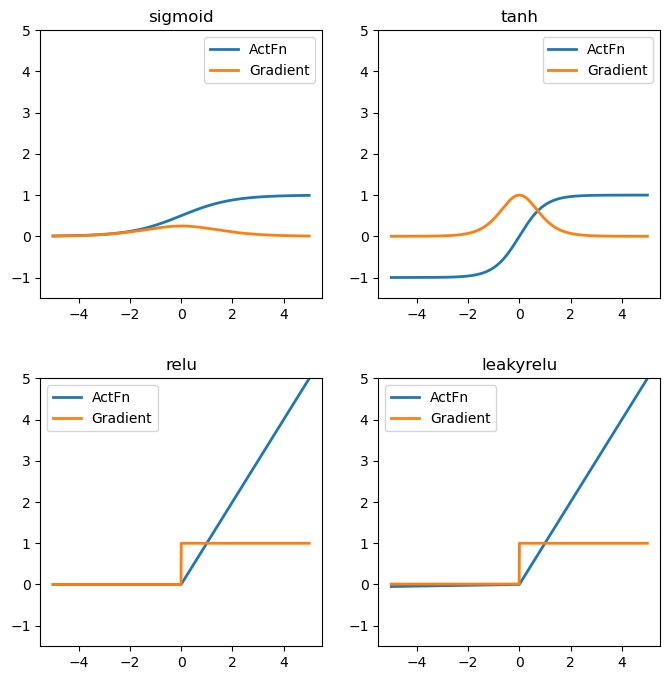

In [19]:
# %matplotlib inline
def vis_act_fn(act_fn, name, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fn_by_name)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, name in enumerate(act_fn_by_name.keys()):
    vis_act_fn(act_fn_by_name[name], name, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()
plt.close()

# Dane
PyTorch posiada zaimplementowanych kilka funkcjonalności, które pozwalają wczytywać i manipulować danymi. Znajdują się one w pakiecie torch.utils.data.

In [20]:
import torch.utils.data as data

Główną strukturą, w ramach której przechowywane (lub niekoniecznie) są dane jest klasa Dataset. Stwórzmy sobie przykładowy zbiór danych - tzw. ciągły XOR. Przykład zaczerpnięty z https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html#Learning-by-example:-Continuous-XOR

In [21]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [22]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([1.0275, 0.0544]), tensor(1))


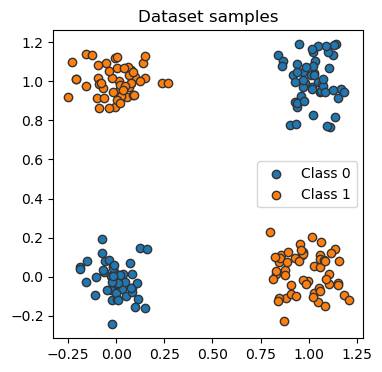

In [23]:
examples = dataset.data
labels = dataset.label
data_0 = examples[labels == 0]
data_1 = examples[labels == 1]

plt.figure(figsize=(4,4))
plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
plt.title("Dataset samples")
plt.legend()
plt.show()

## Data loaders (Ładowacze danych?!)

In [24]:
data_loader = data.DataLoader(dataset,batch_size=8, shuffle=True)

In [25]:
next(iter(data_loader))

[tensor([[ 0.1131, -0.1150],
         [ 1.1658,  0.9603],
         [ 0.8870,  0.0738],
         [-0.0889,  0.9878],
         [ 0.7967,  0.2268],
         [ 1.0150,  0.9689],
         [ 0.9877,  1.0747],
         [-0.0890,  0.8608]]),
 tensor([0, 0, 1, 1, 1, 0, 0, 1])]

In [26]:
len(data_loader)

25

In [27]:
next(iter(data_loader))[0].shape[0]*len(data_loader)

200

In [28]:
data_loader_2 = data.DataLoader(dataset,batch_size=7, shuffle=True)
next(iter(data_loader_2))[0].shape[0]*len(data_loader_2)

203

In [29]:
list(iter(data_loader_2))[-1]

[tensor([[-0.1099, -0.0932],
         [ 0.0839, -0.0585],
         [ 0.9797,  0.9929],
         [ 0.8927,  0.1259]]),
 tensor([0, 0, 0, 1])]

#### Drop last
Parametr powodujący pominięcie ostatniego wsadu (batch), gdy nie jest on pełnym batchem (np. nie ma 8 elementów, a jedynie 6)

In [30]:
data_loader_2 = data.DataLoader(dataset,batch_size=7, shuffle=True, drop_last=True)
next(iter(data_loader_2))[0].shape[0]*len(data_loader_2)

196

## Funkcje straty
Na poprzednich zajęciach obliczaliśmy funkcję straty ręcznie wykonując operacje na tensorach. Jest to w pełni poprawne rozwiązanie, ale możemy też nie wymyślać koła na nowo, ale wykorzystać wbudowane moduły. Pełna lista dostępna tutaj: https://pytorch.org/docs/stable/nn.html#loss-functions

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [32]:
tensor_1 = torch.arange(5.)
tensor_2 = torch.ones(5)
print(tensor_1, tensor_2)

tensor([0., 1., 2., 3., 4.]) tensor([1., 1., 1., 1., 1.])


### Błąd średniokwadratowy (Mean Squared Error) lub L2Loss

In [33]:
loss = nn.MSELoss()
loss(tensor_1,tensor_2)

tensor(3.)

$ \quad l_{n}=\left(x_{n}-y_{n}\right)^{2}$

In [34]:
loss = nn.MSELoss(reduction="none")  # obliczenie squared error dla kazdego przykladu
print(f"No reduction: {loss(tensor_1,tensor_2)}")
loss = nn.MSELoss(reduction="mean")  # normalne MSE
print(f"Mean: {loss(tensor_1,tensor_2)}")
loss = nn.MSELoss(reduction="sum")  # sama suma, bez dzielenia
print(f"Sum: {loss(tensor_1,tensor_2)}")

No reduction: tensor([1., 0., 1., 4., 9.])
Mean: 3.0
Sum: 15.0


In [35]:
F.mse_loss(tensor_1, tensor_2)  # Functional

tensor(3.)

In [36]:
# loss = nn.MSELoss(reduction="none")
# x, y = torch.meshgrid(torch.linspace(0,10,100),torch.linspace(0,10,100))
# z = loss(x,y)

# fig = plt.figure()
# ax = fig.gca(projection='3d')

# ax.plot_trisurf(x.numpy().flatten(), y.numpy().flatten(), z.numpy().flatten(), linewidth=0.2, antialiased=True)

# plt.show()

### Błąd bezwzględny (Mean absolute Error) lub L1Loss

$ \quad l_{n}=\left|x_{n}-y_{n}\right|$

In [37]:
print(tensor_1, tensor_2)
loss = nn.L1Loss()
loss(tensor_1,tensor_2)

tensor([0., 1., 2., 3., 4.]) tensor([1., 1., 1., 1., 1.])


tensor(1.4000)

In [38]:
loss = nn.L1Loss(reduction="none")
print(f"No reduction: {loss(tensor_1,tensor_2)}")
loss = nn.L1Loss(reduction="mean")
print(f"Mean: {loss(tensor_1,tensor_2)}")
loss = nn.L1Loss(reduction="sum")
print(f"Sum: {loss(tensor_1,tensor_2)}")

No reduction: tensor([1., 0., 1., 2., 3.])
Mean: 1.399999976158142
Sum: 7.0


In [39]:
# loss = nn.L1Loss(reduction="none")
# x, y = torch.meshgrid(torch.linspace(0,10,100),torch.linspace(0,10,100))
# z = loss(x,y)

# fig = plt.figure()
# ax = fig.gca(projection='3d')

# ax.plot_trisurf(x.numpy().flatten(), y.numpy().flatten(), z.numpy().flatten(), linewidth=0.2, antialiased=True)

# plt.show()

### Entropia krzyżowa:
$l_{n}=-\left[y_{n} \cdot \log x_{n}+\left(1-y_{n}\right) \cdot \log \left(1-x_{n}\right)\right]$

In [40]:
tensor_1 = torch.rand(5)
tensor_2 = torch.ones(5)
print(tensor_1, tensor_2)
loss = nn.BCELoss(reduction="none")
loss(tensor_1,tensor_2)

tensor([0.8786, 0.9396, 0.1534, 0.2241, 0.1327]) tensor([1., 1., 1., 1., 1.])


tensor([0.1294, 0.0624, 1.8745, 1.4959, 2.0196])

In [41]:
loss = nn.BCEWithLogitsLoss(reduction="none")
loss(tensor_1*10,tensor_2)

tensor([1.5281e-04, 8.3085e-05, 1.9524e-01, 1.0111e-01, 2.3527e-01])

In [42]:
# loss = nn.BCEWithLogitsLoss(reduction="none")
# x, y = torch.meshgrid(torch.linspace(-10,10,100),torch.linspace(-10,10,100))
# z = loss(x,y)

# fig = plt.figure()
# ax = fig.gca(projection='3d')

# ax.plot_trisurf(x.numpy().flatten(), y.numpy().flatten(), z.numpy().flatten(), linewidth=0.2, antialiased=True)

# plt.show()

# Optymalizacja parametrów
W przykładowym problemie optymalizacji parametrów regresji ręcznie aktualizowaliśmy gradienty. W torch są do tego narzędzia zwane optymalizatorami, znajdują się one w pakiecie torch.optim.

Najprostszym optymalizatorem jest algorytm stochastycznego spadku gradientu (Stochastic Gradient Descent) - SGD

In [43]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

## Połączmy to wszystko razem

In [45]:
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [46]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [47]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [48]:
loss_module = nn.BCEWithLogitsLoss()

In [49]:
model.train() 

# Training loop
for epoch in range(100):
    for data_inputs, data_labels in train_data_loader:

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels.float())

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero. 
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad() 
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()
    print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.694
Epoch: 1, loss: 0.685
Epoch: 2, loss: 0.69
Epoch: 3, loss: 0.689
Epoch: 4, loss: 0.683
Epoch: 5, loss: 0.679
Epoch: 6, loss: 0.681
Epoch: 7, loss: 0.68
Epoch: 8, loss: 0.69
Epoch: 9, loss: 0.679
Epoch: 10, loss: 0.677
Epoch: 11, loss: 0.68
Epoch: 12, loss: 0.676
Epoch: 13, loss: 0.67
Epoch: 14, loss: 0.674
Epoch: 15, loss: 0.667
Epoch: 16, loss: 0.674
Epoch: 17, loss: 0.676
Epoch: 18, loss: 0.683
Epoch: 19, loss: 0.668
Epoch: 20, loss: 0.674
Epoch: 21, loss: 0.659
Epoch: 22, loss: 0.662
Epoch: 23, loss: 0.651
Epoch: 24, loss: 0.648
Epoch: 25, loss: 0.656
Epoch: 26, loss: 0.654
Epoch: 27, loss: 0.645
Epoch: 28, loss: 0.639
Epoch: 29, loss: 0.643
Epoch: 30, loss: 0.654
Epoch: 31, loss: 0.63
Epoch: 32, loss: 0.634
Epoch: 33, loss: 0.626
Epoch: 34, loss: 0.619
Epoch: 35, loss: 0.604
Epoch: 36, loss: 0.595
Epoch: 37, loss: 0.61
Epoch: 38, loss: 0.612
Epoch: 39, loss: 0.595
Epoch: 40, loss: 0.6
Epoch: 41, loss: 0.586
Epoch: 42, loss: 0.557
Epoch: 43, loss: 0.582
Epoch: 

### Ewaluacja

In [50]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [51]:
model.eval() # Set model to eval mode
true_preds, num_preds = 0., 0.

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in train_data_loader:

        # Determine prediction of model on dev set
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1)
        preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
        pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

        # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
        true_preds += (pred_labels == data_labels).sum()
        num_preds += data_labels.shape[0]

acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Accuracy of the model: 99.80%


In [52]:
from matplotlib.colors import to_rgba

/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


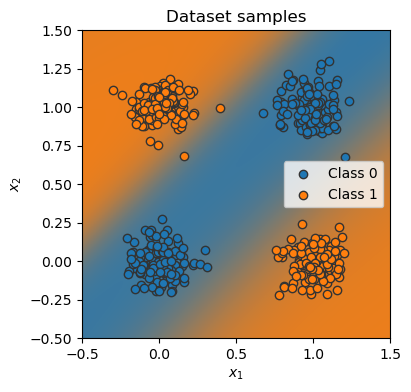

In [53]:
with torch.no_grad():
    data = test_dataset.data.cpu().numpy()
    label = test_dataset.label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2) # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = preds * c0[None,None] + (1 - preds) * c1[None,None] # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy() # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='upper', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)

## Zapisywanie i wczytywanie modelu

In [54]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[ 0.1620,  0.7488],
        [ 1.3610,  1.4988],
        [-0.8577, -0.0352],
        [ 2.6224,  2.5405]], device='mps:0')), ('linear1.bias', tensor([ 0.6061, -2.0992, -0.0357, -1.0434], device='mps:0')), ('linear2.weight', tensor([[-0.6129, -2.5874,  0.8430,  3.2028]], device='mps:0')), ('linear2.bias', tensor([-1.7270], device='mps:0'))])


In [55]:
torch.save(state_dict, "simple_model.tar")

In [56]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("simple_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.cpu().state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[ 0.1620,  0.7488],
        [ 1.3610,  1.4988],
        [-0.8577, -0.0352],
        [ 2.6224,  2.5405]])), ('linear1.bias', tensor([ 0.6061, -2.0992, -0.0357, -1.0434])), ('linear2.weight', tensor([[-0.6129, -2.5874,  0.8430,  3.2028]])), ('linear2.bias', tensor([-1.7270]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[ 0.1620,  0.7488],
        [ 1.3610,  1.4988],
        [-0.8577, -0.0352],
        [ 2.6224,  2.5405]])), ('linear1.bias', tensor([ 0.6061, -2.0992, -0.0357, -1.0434])), ('linear2.weight', tensor([[-0.6129, -2.5874,  0.8430,  3.2028]])), ('linear2.bias', tensor([-1.7270]))])


## Zrób to sam:

Spróbujmy przewidzieć ocenę wina na podstawie jego parametrów

In [57]:
import seaborn as sns

In [58]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")

In [59]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [61]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [62]:
df.shape

(4898, 12)

In [63]:
df['quality'] = df['quality'] - 3

In [64]:
# pd.get_dummies(df, columns=['quality'])

In [65]:
df['quality'].value_counts()

3    2198
2    1457
4     880
5     175
1     163
0      20
6       5
Name: quality, dtype: int64

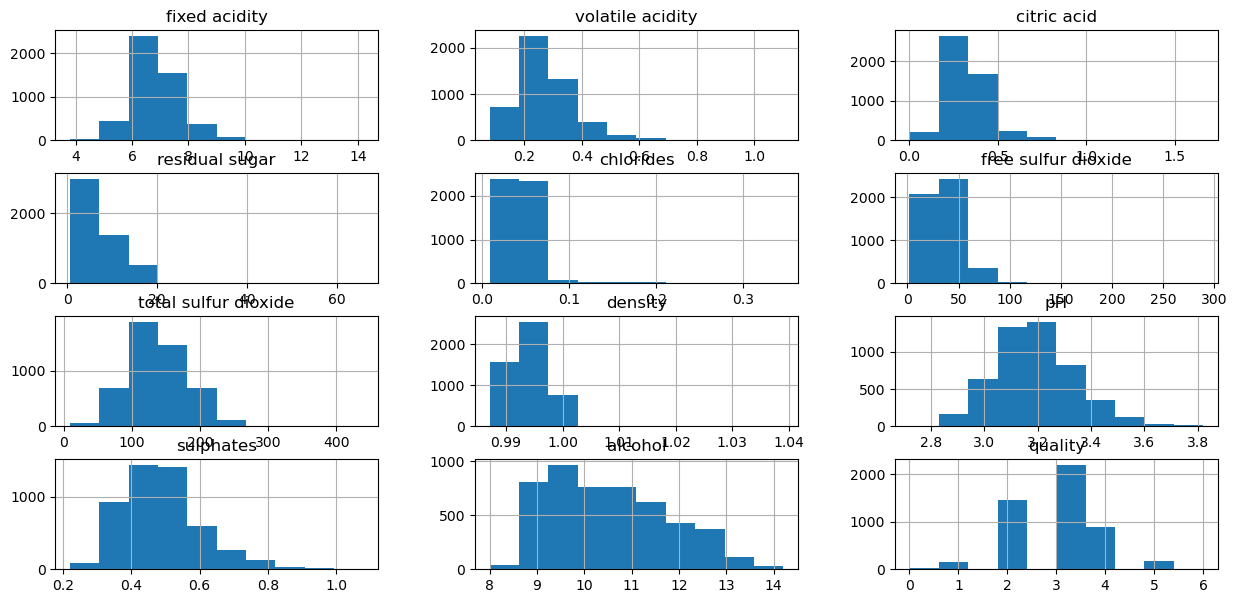

In [66]:
df.hist(figsize=(15, 7))
plt.show()

<AxesSubplot: xlabel='quality', ylabel='count'>

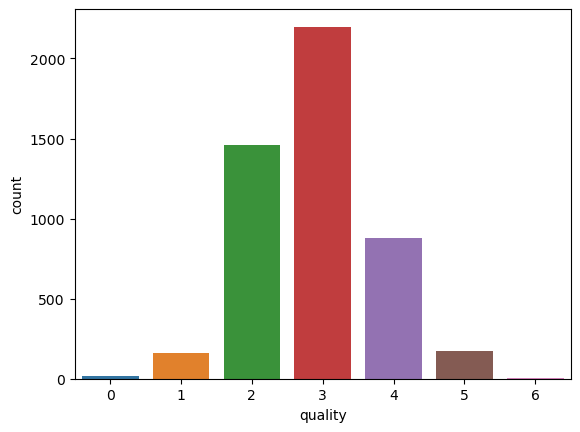

In [67]:
# sns.countplot(df['quality'])
sns.countplot(x='quality', data=df)

Niezbalansowane dane

#### ... Jakieś wstępne przetwarzanie danych?

In [68]:
train = df.sample(frac=0.8, random_state=200) #random state is a seed value
test = df.drop(train.index)

### Skalowanie danych

### Dataset + DataLoader

In [69]:
import torch.utils.data as data
from numpy import dtype


train_dataset = data.TensorDataset(torch.from_numpy(train.values[:, :-1]).type(torch.float32),
                                   torch.from_numpy(train.values[:, -1]).type(torch.LongTensor))

test_dataset = data.TensorDataset(torch.from_numpy(test.values[:, :-1]).type(torch.float32),
                                  torch.from_numpy(test.values[:, -1]).type(torch.LongTensor))
# next(iter(train_dataset))

In [70]:
print(len(train_dataset))
print(len(test_dataset))

3918
980


In [71]:
train_dataloader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataloader = data.DataLoader(test_dataset, batch_size=64)

## Model

In [87]:
class ClassificationModel(nn.Module):
    def __init__(self, input_features, hidden_1, output_features, device='cpu') -> None:
        super().__init__()
        self.device = device
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, hidden_1),
            nn.Sigmoid(),
            # nn.Linear(hidden_1, hidden_1),
            # nn.Tanh()
        )
        # self.dropout = nn.Dropout(0.1)
        self.output_layer = nn.Linear(hidden_1, output_features)

    def forward(self, x):
        x = self.linear_relu_stack(x)
        # x = self.dropout(x)
        x = self.output_layer(x)
        return x
    
    def predict_class(self, x):
        y_pred = self.forward(x)
        return [torch.argmax(pred).item() for pred in y_pred]
    
    def fit(self, train_dataloader, loss_func, optimizer, epochs, val_dataloader=None):
        train_report = {
            'train_loss_history': []
        }
        
        if val_dataloader is not None:
            train_report['val_loss_history'] = []
        
        self.train()
        for epoch in range(epochs):
            train_epoch_loss = self.__train_one_epoch(train_dataloader, loss_func, optimizer)
              
            avg_epoch_loss = train_epoch_loss / len(train_dataloader)
            train_report['train_loss_history'].append(avg_epoch_loss)
            print('================================')
            print(f'Epoch: {epoch}, Train Loss: {avg_epoch_loss}')
            
            if val_dataloader is not None:
                val_loss = self.perform_validation(val_dataloader, loss_func)
                train_report['val_loss_history'].append(val_loss)
                print(f'Val Loss: {val_loss}')
            
        return train_report

    def perform_validation(self, validation_dataloader, loss_func):
        val_loss = 0.0
        with torch.no_grad():
            for sample_batch, label_batch in validation_dataloader:
                x = sample_batch.to(self.device)
                y = label_batch.to(self.device)
                
                y_pred = self.forward(x)
                loss = loss_func(y_pred, y)
                val_loss += loss.item()
            
            avg_val_loss = val_loss / len(validation_dataloader)
        return avg_val_loss

    def __train_one_epoch(self, train_dataloader, loss_func, optimizer):
        train_epoch_loss = 0.0
        for sample_batch, label_batch in train_dataloader:
                X = sample_batch.to(self.device)
                y = label_batch.to(self.device)
                
                y_pred = self.forward(X)
                loss = loss_func(y_pred, y)
                train_epoch_loss += loss.item()
                
                self.__optimize_params(loss, optimizer)
        return train_epoch_loss
            

    def __optimize_params(self, loss, optimizer):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
            

## Training

In [88]:
num_classes = 7

In [89]:
device = torch.device("cpu")

In [90]:
model = ClassificationModel(11, 16, num_classes, device=device).to(device)
model

ClassificationModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): Sigmoid()
  )
  (output_layer): Linear(in_features=16, out_features=7, bias=True)
)

In [91]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.015)

In [92]:
train_report = model.fit(train_dataloader, loss_func, optimizer, epochs=15, val_dataloader=test_dataloader)

Epoch: 0, Train Loss: 1.3839128382744328
Val Loss: 1.3247452154755592
Epoch: 1, Train Loss: 1.2885291730203936
Val Loss: 1.3154961615800858
Epoch: 2, Train Loss: 1.2793516555140096
Val Loss: 1.3097730576992035
Epoch: 3, Train Loss: 1.2759794419811619
Val Loss: 1.30083267390728
Epoch: 4, Train Loss: 1.276108193782068
Val Loss: 1.2908101230859756
Epoch: 5, Train Loss: 1.2539867797205526
Val Loss: 1.278749704360962
Epoch: 6, Train Loss: 1.2336755087298732
Val Loss: 1.259297914803028
Epoch: 7, Train Loss: 1.2234677614704255
Val Loss: 1.2487618997693062
Epoch: 8, Train Loss: 1.2055342697328137
Val Loss: 1.2391574308276176
Epoch: 9, Train Loss: 1.2010677860629173
Val Loss: 1.2321738302707672
Epoch: 10, Train Loss: 1.1871861969271014
Val Loss: 1.2229344993829727
Epoch: 11, Train Loss: 1.1803832159888359
Val Loss: 1.2191535420715809
Epoch: 12, Train Loss: 1.1753686637647691
Val Loss: 1.2158805057406425
Epoch: 13, Train Loss: 1.179880037423103
Val Loss: 1.2040243595838547
Epoch: 14, Train Loss:

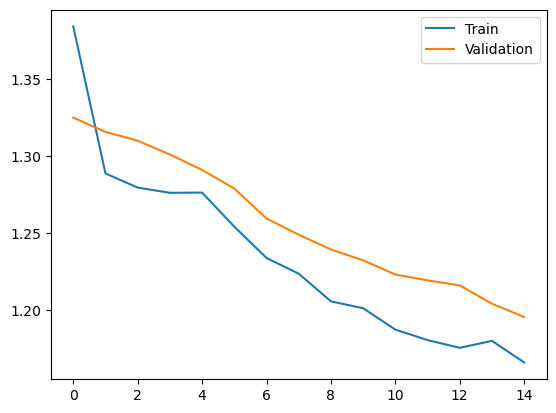

In [93]:
plt.plot(train_report['train_loss_history'], label='Train')
plt.plot(train_report['val_loss_history'], label='Validation')
plt.legend()


## Evaluation

In [94]:
X_test, y_test = test_dataset.tensors[0], test_dataset.tensors[1]
X_test.shape, y_test.shape


(torch.Size([980, 11]), torch.Size([980]))

In [95]:
y_pred = model.predict_class(X_test)

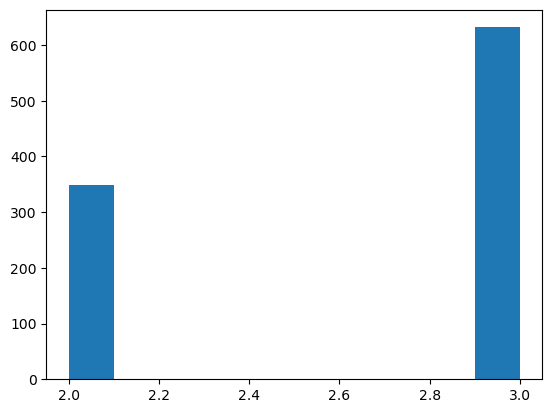

In [96]:
plt.hist(y_pred)
plt.show()

In [97]:
accuracy_score(y_test, y_pred)

0.48367346938775513

In [98]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00        35
           2       0.51      0.57      0.53       311
           3       0.47      0.72      0.57       416
           4       0.00      0.00      0.00       172
           5       0.00      0.00      0.00        39

    accuracy                           0.48       980
   macro avg       0.16      0.21      0.18       980
weighted avg       0.36      0.48      0.41       980



/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TODO

- [x] Accuracy
- [x] F1 score (classification report)
- Torch Scaling
- OHE labels